Here we try to train the GAN locally as the VM crashes. It will be slower, but better than nothing.

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from utils.dataset import CocoDataset
from utils.plots import plot_l, plot_model_pred, plot_losses
from utils.models import EncoderDecoderGenerator, PatchGAN, save_model, load_model
from utils.metrics import evaluate_model
from utils.training import train_gan, load_losses

device = "cuda" if torch.cuda.is_available() else "cpu"
height, width = 256, 256
path_sandro = "coco/images/train2014"
transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
])
dataset = CocoDataset(root=path_sandro, transform=transform)

Found 82783 images.


In [2]:
torch.manual_seed(42)
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
train, test = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)

In [3]:
torch.manual_seed(42)
generator = EncoderDecoderGenerator().to(device)
generator_opt = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

discriminator = PatchGAN().to(device)
discriminator_opt = optim.SGD(discriminator.parameters(), lr=0.0002, momentum=0.9, nesterov=True)

criterion = nn.BCELoss()

In [4]:
torch.manual_seed(42)
d_losses0, g_losses0 = train_gan(10, discriminator, generator, discriminator_opt, generator_opt,
                               criterion, train_loader, device, l1_lambda=0.5, label_smoothing=True,
                               add_noise=True, save_checkpoints=True, save_losses=True, file_name="localgen0")

Epoch 10/10: 100%|██████████| 2070/2070 [47:02<00:00,  1.36s/it, d_loss=0.691, g_loss=0.787]

Losses saved to losses\localgen0_losses.txt
Finished Training


since loss plateus, either the gan has rechead it's nash equilibrium, or that it got stuck in some suboptimal local minima. we could fix this by adjusting the learning rate for example with some scheduling. yet, the fact that losses change steadily and don't osccilate is a good sign that training may proceeed smoothly.

In [5]:
save_model(generator, "localgen0")

Model saved to models\localgen0.pth successfully!


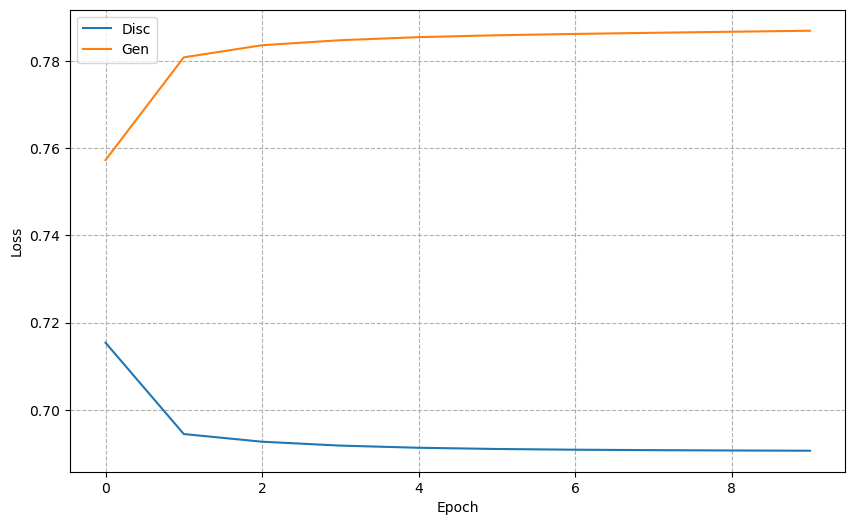

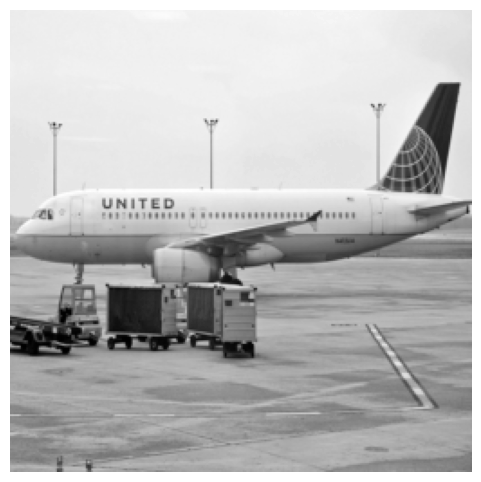

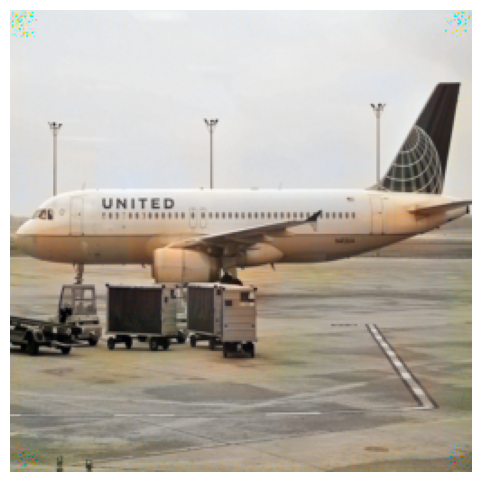

In [6]:
plot_losses(d_losses0, g_losses0, "Disc", "Gen")
plot_l(dataset[7653][1])
plot_model_pred(dataset[7653][1], generator, device)

In [7]:
torch.manual_seed(42)
avg_mse, std_mse, avg_psnr, std_psnr, avg_ssim, std_ssim, fid = evaluate_model(generator, test_loader, device)
print(f"Average MSE, STD: {avg_mse:.4f}, {std_mse:.4f}")
print(f"Average PSNR, STD: {avg_psnr:.4f}, {std_psnr:.4f}")
print(f"Average SSIM, STD: {avg_ssim:.4f}, {std_ssim:.4f}")
print(f"FID: {fid:.4f}")

Average MSE, STD: 0.0031, 0.0005
Average PSNR, STD: 50.2292, 1.4314
Average SSIM, STD: 0.7556, 0.0862
FID: 10.5602


In [8]:
# keep on training from epoch 10
torch.manual_seed(42)
d_losses1, g_losses1 = train_gan(10, discriminator, generator, discriminator_opt, generator_opt,
                               criterion, train_loader, device, l1_lambda=0.5, label_smoothing=True,
                               add_noise=True, save_checkpoints=True, save_losses=True, file_name="localgen1")

Epoch 10/10: 100%|██████████| 2070/2070 [47:38<00:00,  1.38s/it, d_loss=0.69, g_loss=0.789]

Losses saved to losses\localgen1_losses.txt
Finished Training


In [9]:
save_model(generator, "localgen1")

Model saved to models\localgen1.pth successfully!


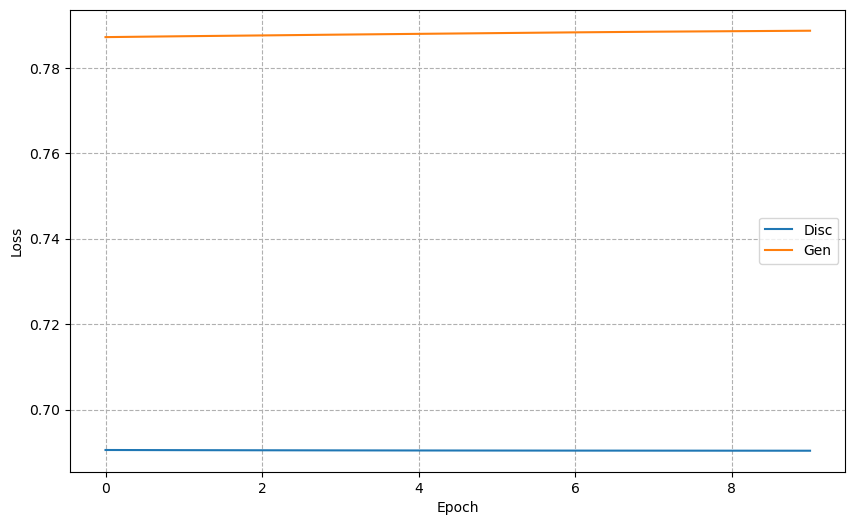

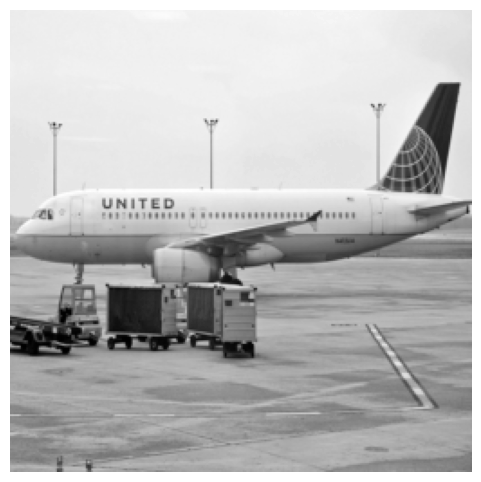

c:\Users\sandr\Desktop\ML\project\image-colorization\utils\plots.py:129: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_reconstructed)


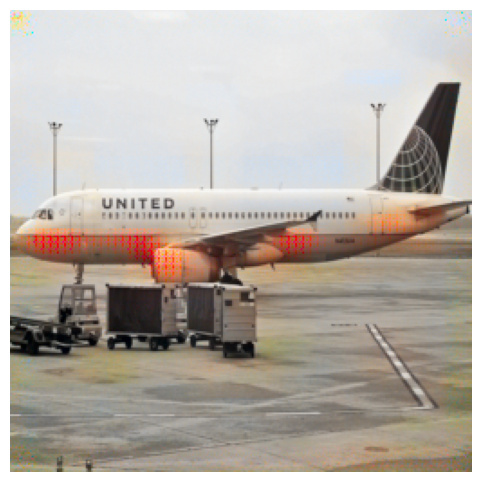

In [10]:
plot_losses(d_losses1, g_losses1, "Disc", "Gen")
plot_l(dataset[7653][1])
plot_model_pred(dataset[7653][1], generator, device)

In [11]:
torch.manual_seed(42)
avg_mse, std_mse, avg_psnr, std_psnr, avg_ssim, std_ssim, fid = evaluate_model(generator, test_loader, device)
print(f"Average MSE, STD: {avg_mse:.4f}, {std_mse:.4f}")
print(f"Average PSNR, STD: {avg_psnr:.4f}, {std_psnr:.4f}")
print(f"Average SSIM, STD: {avg_ssim:.4f}, {std_ssim:.4f}")
print(f"FID: {fid:.4f}")

Average MSE, STD: 0.0031, 0.0005
Average PSNR, STD: 50.3388, 1.4666
Average SSIM, STD: 0.7414, 0.0909
FID: 14.4715


# Test a bit

In [13]:
model10 = load_model(EncoderDecoderGenerator(), "models/localgen0.pth").to(device)
model20 = load_model(EncoderDecoderGenerator(), "models/localgen1.pth").to(device)

EncoderDecoderGenerator model loaded successfully!
EncoderDecoderGenerator model loaded successfully!


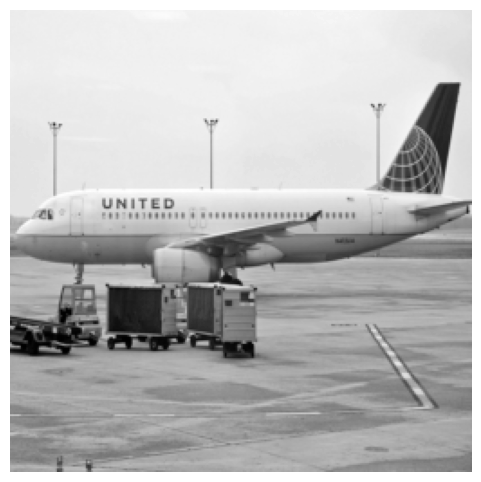

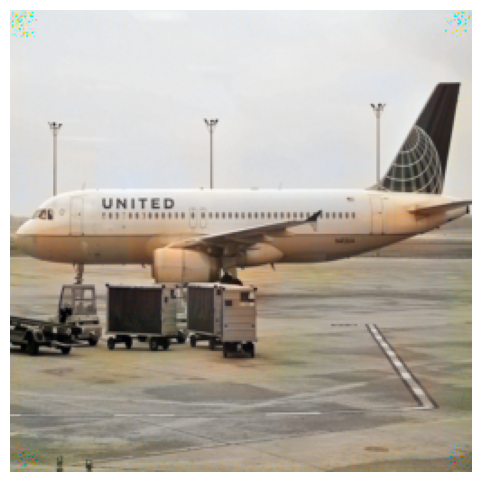

c:\Users\sandr\Desktop\ML\project\image-colorization\utils\plots.py:129: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_reconstructed)


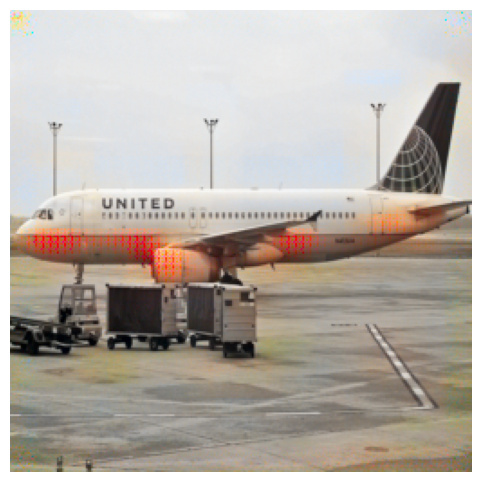

In [15]:
idx = 7653
plot_l(dataset[idx][1])
plot_model_pred(dataset[idx][1], model10, device)
plot_model_pred(dataset[idx][1], model20, device)

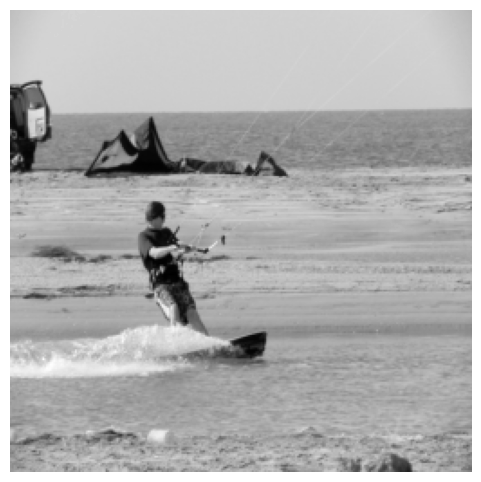

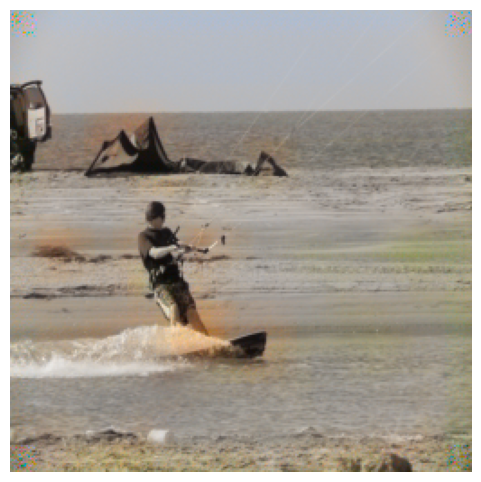

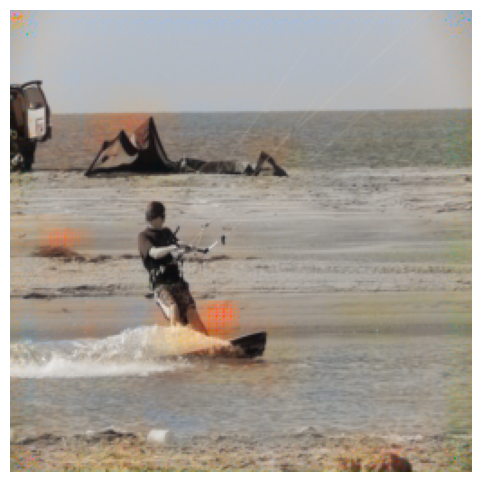

In [24]:
idx = 4567
plot_l(dataset[idx][1])
plot_model_pred(dataset[idx][1], model10, device)
plot_model_pred(dataset[idx][1], model20, device)

artifacts may come from the fact that discriminator converges to a fixed loss and generator has no way to understand how to fool, maybe vanishing gradients...